# Mutliple multiplications

See README for problem setup.

In [1]:
import torch
from torch import nn
from torch.optim import Adam
from matplotlib import pyplot as plt
from matplotlib import cm
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np

from physics_mi.utils import set_all_seeds

In [2]:
# seed = np.random.randint(1, 2**32 - 1)
seed = 689334534
set_all_seeds(seed)
print(seed)

689334534


## Model

Keeping this extremely simple

In [3]:
class LinearLayer(nn.Module):
    def __init__(self, in_feats, out_feats, use_act=True, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.linear = nn.Linear(in_feats, out_feats)
        if use_act:
            self.act = nn.ReLU()
        self.use_act = use_act

    def forward(self, x):
        x = self.linear(x)
        if self.use_act:
            x = self.act(x)
        return x


class Net(nn.Module):
    def __init__(self, input_dim=4, hidden_dim=16, output_dim=2, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.layers = nn.Sequential(
            LinearLayer(input_dim, hidden_dim, use_act=True),
            LinearLayer(hidden_dim, output_dim, use_act=False),
        )

    def forward(self, x):
        return self.layers(x)

## Data

In [4]:
import torch

# Number of samples
n_samples = 10000

# Epsilon value
eps = 0.5


# Generate Y values
def generate_Y(n_samples):
    return torch.rand(n_samples)


# Generate X values based on Y
def generate_X(Y, eps):
    X = torch.empty(len(Y), 2)
    X[:, 0] = Y / (torch.rand(len(Y)) * (1 - eps) + eps)
    X[:, 1] = Y / X[:, 0]

    # Randomly swap x1 and x2
    mask = torch.rand(len(Y)) < 0.5
    swap_vals = X[:, 0][mask]
    X[:, 0][mask] = X[:, 1][mask]
    X[:, 1][mask] = swap_vals

    return X


# Initial generation
Y1 = generate_Y(n_samples)
X1 = generate_X(Y1, eps)

# Ensure they are statistically independent by generating new Y and X values
Y2 = generate_Y(n_samples)
X2 = generate_X(Y2, eps)

# Stack X1 and X2 to get the desired shape
X = torch.cat((X1, X2), dim=1)

# Stack Y1 and Y2 for the desired shape
Y = torch.stack((Y1, Y2), dim=1)

# Validate the relationship
assert torch.allclose(X[:, 0] * X[:, 1], Y[:, 0])
assert torch.allclose(X[:, 2] * X[:, 3], Y[:, 1])

# Print the shapes
print(X.shape, Y.shape)

torch.Size([10000, 4]) torch.Size([10000, 2])


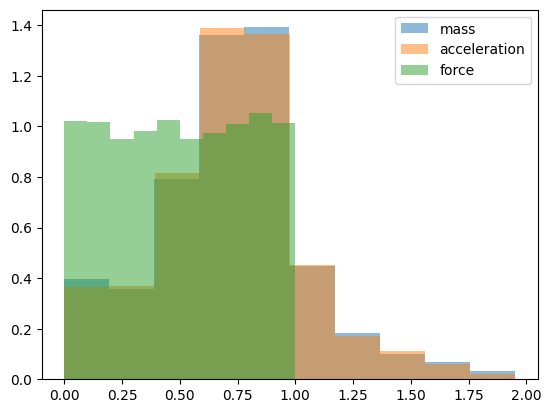

In [5]:
fig, ax = plt.subplots()

ax.hist(X[:, 0], alpha=0.5, density=True, label="mass")
ax.hist(X[:, 1], alpha=0.5, density=True, label="acceleration")
ax.hist(Y[:, 0], alpha=0.5, density=True, label="force")
ax.legend()

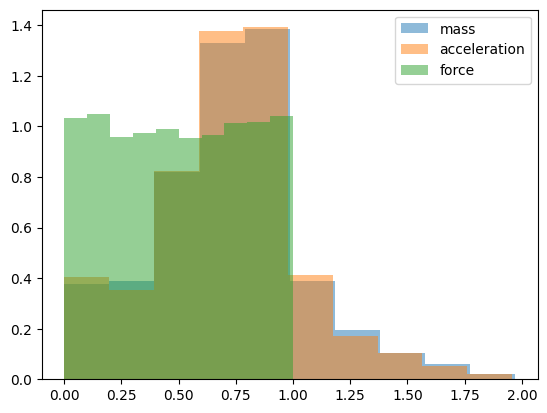

In [6]:
fig, ax = plt.subplots()

ax.hist(X[:, 2], alpha=0.5, density=True, label="mass")
ax.hist(X[:, 3], alpha=0.5, density=True, label="acceleration")
ax.hist(Y[:, 1], alpha=0.5, density=True, label="force")
ax.legend()

Ok, both now look identically distributed.

In [7]:
s_inds = np.random.permutation(range(X.shape[0]))  # shuffled indices

X_train = X[s_inds[:8000]]
Y_train = Y[s_inds[:8000]]
X_valid = X[s_inds[8000:]]
Y_valid = Y[s_inds[8000:]]

X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape

(torch.Size([8000, 4]),
 torch.Size([8000, 2]),
 torch.Size([2000, 4]),
 torch.Size([2000, 2]))

## Training

I'll just do full gradient descent to keep things simple.

In [8]:
N = 4000  # number of epochs

model = Net(input_dim=4, hidden_dim=16, output_dim=2)
loss_func = nn.MSELoss()
optimiser = Adam(model.parameters(), lr=1e-2)
log = []

for i in tqdm(range(N)):
    log_sample = {}

    # Training update
    model.train()
    model.zero_grad()
    Y_hat = model(X_train)
    loss = loss_func(Y_hat, Y_train)
    log_sample["train_loss"] = float(loss.detach())
    loss.backward()
    optimiser.step()

    # Validation set
    model.eval()
    Y_hat = model(X_valid)
    loss = loss_func(Y_hat, Y_valid)
    log_sample["valid_loss"] = float(loss.detach())

    log.append(log_sample)

df = pd.DataFrame(log)

  0%|          | 0/4000 [00:00<?, ?it/s]

## Results

In [17]:
from physics_mi.eval import *


# need to avoid flattening here because we have multiple outputs
def get_preds(model, X_valid, Y_valid):
    model.eval()

    with torch.inference_mode():
        out = model(X_valid)

    y_preds = out.numpy()
    y_targs = Y_valid.numpy()

    return y_preds, y_targs

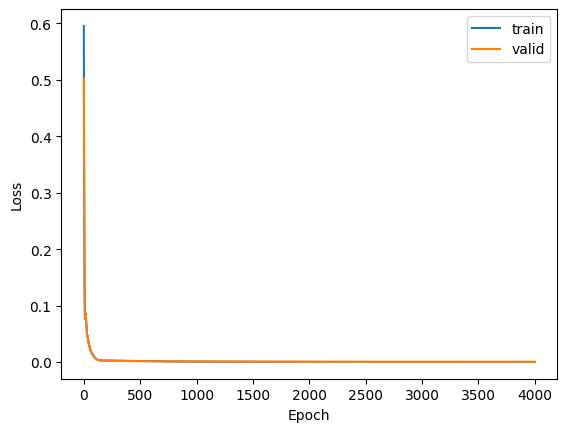

In [18]:
plot_loss(df["train_loss"], df["valid_loss"])

In [19]:
y_preds, y_targs = get_preds(model, X_valid, Y_valid)
y_preds.shape, y_targs.shape

((2000, 2), (2000, 2))

In [20]:
get_valid_loss(model, loss_func, X_valid, Y_valid)

tensor(0.0003)

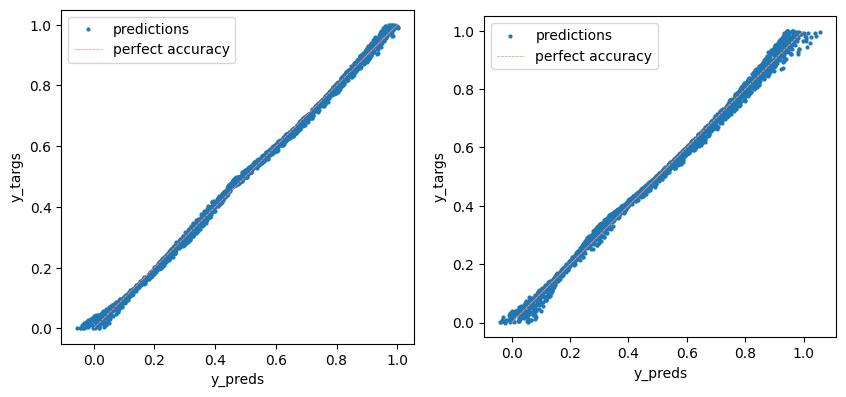

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(10, 10))

plot_results(y_preds[:, 0], y_targs[:, 0], ax=axes[0])
plot_results(y_preds[:, 1], y_targs[:, 1], ax=axes[1])

Both tasks seem to be doing well in parallel 👍

## Introspection

In [22]:
model

Net(
  (layers): Sequential(
    (0): LinearLayer(
      (linear): Linear(in_features=4, out_features=16, bias=True)
      (act): ReLU()
    )
    (1): LinearLayer(
      (linear): Linear(in_features=16, out_features=2, bias=True)
    )
  )
)

In [23]:
for name, param in model.named_parameters():
    print(name, "\n", param.data, "\n")

layers.0.linear.weight 
 tensor([[-5.8990e-01,  6.2029e-01,  5.3083e-04,  2.7631e-03],
        [ 6.5477e-01, -6.6935e-01, -1.3134e-03,  3.2440e-03],
        [-9.1876e-02,  2.9026e-01, -7.9632e-02,  5.9960e-01],
        [ 4.3259e-01, -5.8857e-02, -1.2830e-01,  8.2532e-02],
        [ 1.5291e-03, -6.3556e-03,  7.1866e-01,  7.2679e-01],
        [ 4.2171e-01,  4.3867e-01,  9.9955e-04, -3.2643e-04],
        [ 9.4634e-02,  2.3329e-01,  3.8224e-01, -2.0694e-01],
        [-5.2186e-02,  1.9124e-01, -3.1212e-01, -4.7152e-02],
        [ 3.2089e-01, -2.3463e-01,  6.4656e-01,  4.1532e-01],
        [ 2.1481e-01, -4.2382e-01, -3.8562e-01, -2.3305e-01],
        [-3.9773e-02, -2.2027e-01,  1.1443e-01,  5.5562e-02],
        [ 4.2238e-01,  6.7249e-01,  1.2699e-01,  6.1671e-01],
        [ 7.3213e-01,  7.6478e-01, -1.8074e-02, -4.8249e-01],
        [ 4.4857e-03,  1.9032e-02, -7.2403e-01,  7.5890e-01],
        [-3.6320e-01, -2.9775e-01, -1.0330e-01, -1.6502e-01],
        [ 3.8743e-01,  1.0631e-01,  1.2086e-0

### Inspect intermediate values

In [24]:
from collections import OrderedDict
import torch
import torch.nn as nn


def capture_intermediate_outputs(model, input_tensor):
    """
    Captures the intermediate outputs of a PyTorch model.

    Args:
        model: A PyTorch model.
        input_tensor: A PyTorch tensor of shape (batch_size, *).
    Returns:
        A dictionary mapping layer names to intermediate outputs.
    """
    intermediate_values = OrderedDict()

    def hook_fn(module, input, output, name):
        if isinstance(module, nn.Linear):
            weight = module.weight
            input_value = input[0]
            intermediate_output = input_value.matmul(weight.t())
            intermediate_values[f"{name}.weight"] = intermediate_output
            intermediate_values[f"{name}.bias"] = output
        else:
            intermediate_values[name] = output

    hooks = []
    for name, layer in model.named_modules():
        hook = layer.register_forward_hook(
            lambda module, input, output, name=name: hook_fn(module, input, output, name)
        )
        hooks.append(hook)

    with torch.inference_mode():
        _ = model(input_tensor)

    for hook in hooks:
        hook.remove()

    filtered_values = {k: t for k, t in intermediate_values.items() if len(k.split(".")) > 2}
    return filtered_values


# a function that uses capture_intermediate_outputs to give a nice printed summary of the model outputs and parameters
def print_model_summary(model, input_tensor):
    intermediate_values = capture_intermediate_outputs(model, input_tensor)

    for k, v in intermediate_values.items():
        print(f"{k}: {v}")

In [35]:
def plot_neuron_contribution(acts, bias, eps=0.05):
    fig, axes = plt.subplots(4, 4, figsize=(12, 10))  # Increase the width to make space for the colorbar
    axes = axes.flatten()

    for i in range(acts.shape[1]):
        col = acts[:, i]
        activated_mask = acts[:, i].abs() > eps  # really trying to focus on the activated areas
        activated_mask = torch.ones(col.shape, dtype=bool)
        sc = axes[i].scatter(
            pairs[activated_mask, 0],
            pairs[activated_mask, 1],
            c=col[activated_mask],
            cmap="bwr",
            s=50,
            norm=plt.Normalize(vmin=-1, vmax=1),
        )

        axes[i].set_title(f"Node {i+1}")
        axes[i].set_xlabel("x1")
        axes[i].set_ylabel("x2")
        axes[i].set_aspect("equal")
        axes[i].set_xlim(-0.05, 1.05)
        axes[i].set_ylim(-0.05, 1.05)

    # Position the colorbar on the right of the last subplot
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    fig.colorbar(sc, cax=cbar_ax)

    fig.suptitle(f"Output value at layers.1.linear.weight\n(pre addition of {bias:.2f} bias)")
    fig.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust the rectangle in which to fit the subplots

In [33]:
N = 5
pairs = np.concatenate(np.stack(np.meshgrid(np.linspace(0, 1, N), np.linspace(0, 1, N))).T)
pairs = pairs.repeat(2, axis=0).reshape(-1, 4)
outputs = capture_intermediate_outputs(model, torch.as_tensor(pairs).float())
lws = model.state_dict()["layers.1.linear.weight"]
acts = outputs["layers.0.act"]
acts.shape

torch.Size([25, 16])

In [39]:
bias = model.state_dict()["layers.1.linear.bias"]

/var/folders/5z/c8p82vrj5f333s_5w192fbw80000gn/T/ipykernel_89587/2251930888.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust the rectangle in which to fit the subplots


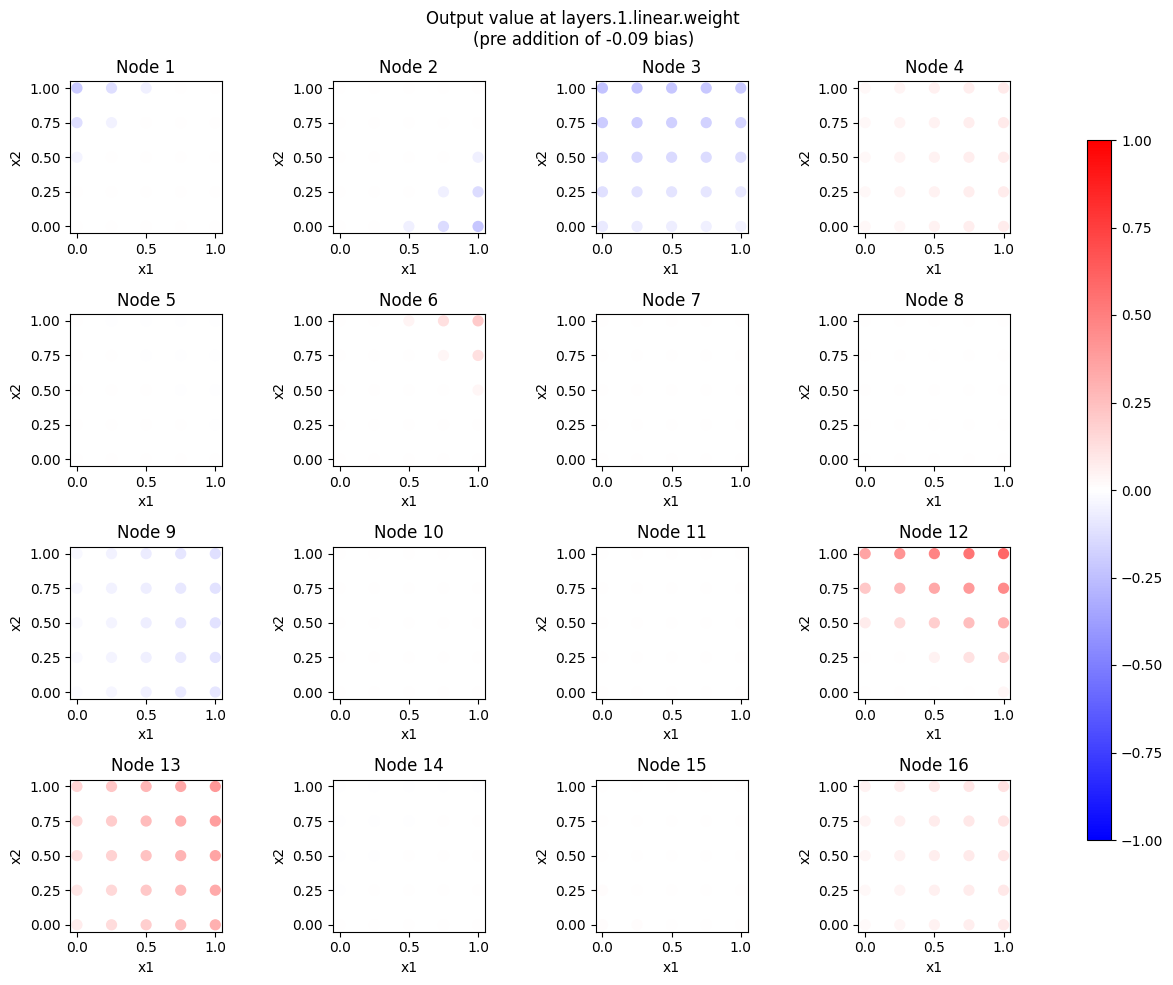

In [40]:
plot_neuron_contribution(acts * lws[0], bias[0], eps=0.05)

/var/folders/5z/c8p82vrj5f333s_5w192fbw80000gn/T/ipykernel_89587/2251930888.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust the rectangle in which to fit the subplots


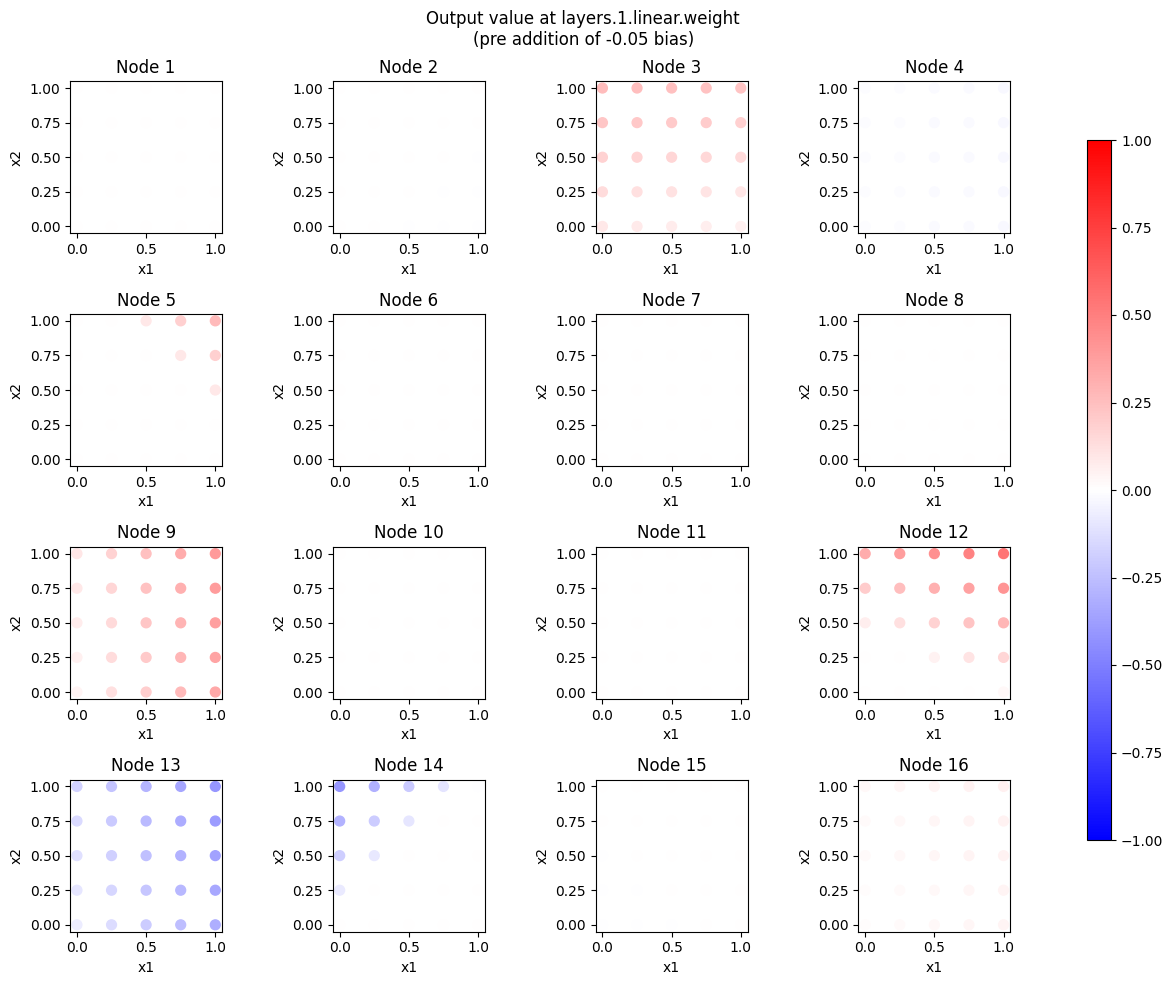

In [41]:
plot_neuron_contribution(acts * lws[1], bias[1], eps=0.05)

Ok, I can roughly see that the neurons are roughly separated by each task, let's try and quantify this.

**NOTE:** to avoid being misleading here, each neuron activation evaluation (each point) in the graphs above is evaluated with the same point being used for the other pair of inputs - that could have some influence so it would be good to explore this...

In [ ]:
ncs = acts[..., None] * lws.t()  # ncs = neuron contributions
ncs.shape

torch.Size([25, 16, 2])

Text(0.5, 1.0, 'Mean neuron contributions across unit square input')

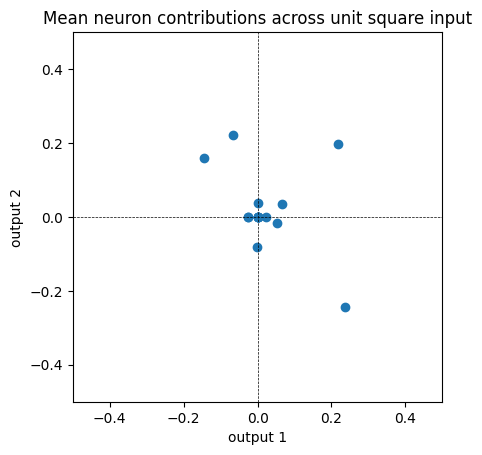

In [ ]:
fig, ax = plt.subplots()

ax.scatter(*ncs.mean(0).numpy().T)
ax.set_aspect("equal")
ax.set_xlim(-0.5, 0.5)
ax.set_ylim(-0.5, 0.5)
ax.vlines(0, -0.5, 0.5, color="k", linestyles="--", lw=0.5)
ax.hlines(0, -0.5, 0.5, color="k", linestyles="--", lw=0.5)

ax.set_xlabel("output 1")
ax.set_ylabel("output 2")
ax.set_title("Mean neuron contributions across unit square input")

This is a correlation plot so we'd really want to see orthogonality to prove that the network is using separate neurons for separate tasks. This would present itself in points sitting on the axes.

Interestingly we're seeing these orthogonal points but definitely a few that also sit decidedly off axis and on the lines $o_1 = o_2$ or $o_1 = -o_2$ (meaning they're highly correlated or anti-correlated - with a gradient of ~1).

I can't quite understand yet why this would be useful to the network. I think I'm going to start by simply training lots of networks and then producing a 2D histogram of where these tend to sit.

I will need to think about the dependencies between the pairs of inputs and how they interact later in the network, because that might cause issues...

In [ ]:
SD = model.state_dict()
W1 = SD["layers.0.linear.weight"].T

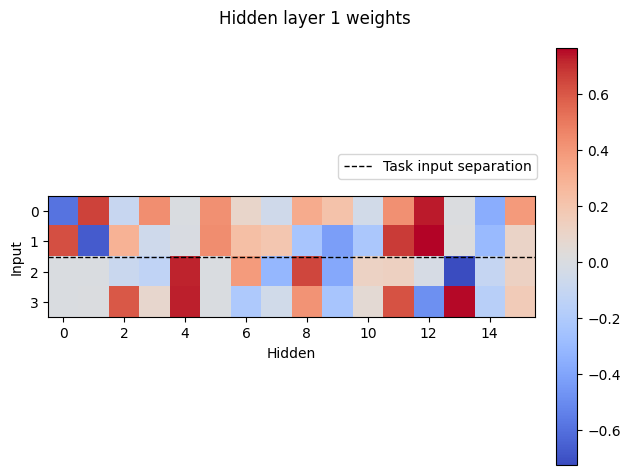

In [ ]:
fig, ax = plt.subplots()

im1 = ax.imshow(W1, cmap="coolwarm")

ax.set_ylabel("Input")
ax.set_xlabel("Hidden")

ax.hlines(1.5, -0.5, 15.5, color="k", lw=1, linestyles="--", label="Task input separation")

ax.legend(loc="upper center", bbox_to_anchor=(0.8, 1.4), ncol=2)
fig.suptitle("Hidden layer 1 weights")
fig.colorbar(im1, ax=ax, orientation="vertical", fraction=0.046, pad=0.04)
_ = fig.tight_layout()

We'd expect here also to see a nice separation of functionality i.e. some neurons are intended for pair 1 and others for pair 2. This is somewhat true, but equally there is mixing on some of the neurons.

I can make a similar graph here to as before:

In [ ]:
pair_weights = torch.stack(
    (W1[:2].abs().mean(0), W1[2:].abs().mean(0))
)  # taking the absolute so we don't get so much cancellation
pair_weights.shape

torch.Size([2, 16])

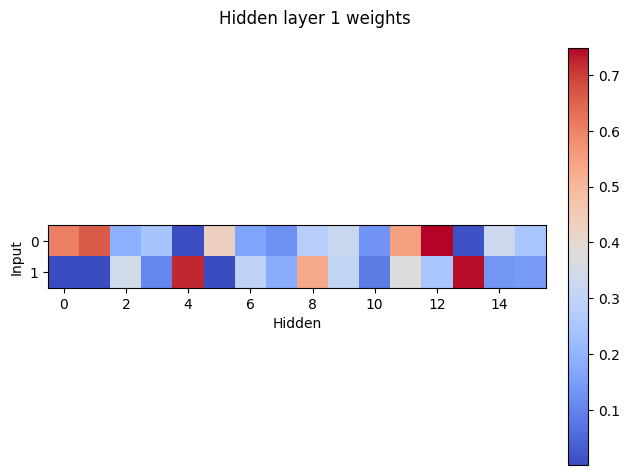

In [ ]:
fig, ax = plt.subplots()

im1 = ax.imshow(pair_weights, cmap="coolwarm")

ax.set_ylabel("Input")
ax.set_xlabel("Hidden")


fig.suptitle("Hidden layer 1 weights")
fig.colorbar(im1, ax=ax, orientation="vertical", fraction=0.046, pad=0.04)
_ = fig.tight_layout()

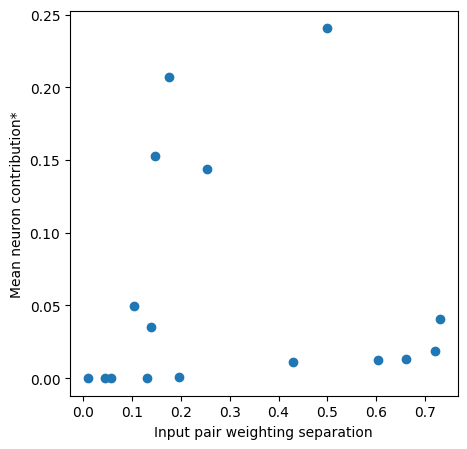

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.scatter(torch.sub(*pair_weights).abs(), ncs.abs().mean(0).mean(1))
ax.set_xlabel("Input pair weighting separation")
_ = ax.set_ylabel("Mean neuron contribution*")

\***NOTE:** remain careful here because this mean neuron contribution is only calculated when the pair 1 and pair 2 have identical values

This _might_ suggest though that the hidden layer neurons only really start having non-zero effect on the output once there is a difference in input weighting fairly above zero. I'm not sure if this makes sense to the reader (probably just me) but this maybe suggests that the network is not really paying any attention to the neurons which take inputs from both pairs (as these could interact destructively)?

Need to do more testing to really confirm this though.

## What to do next

I'd like to investigate the distribution of these multi-task neuron activations and whether they're shared between tasks (finding the distribution across many examples).

The question, is how I evaluate this when there are likely some dependencies on the other pair's inputs (it feels kind of wrong to think that this wouldn't have an effect).

I think probably the best thing to do is to pick random validation set examples for the alternative pair's values at each point. At least then the distribution will be correct and hopefully any anomalies will even out over the repeats.

On _second_ thoughts though... it seems to me that if I break the input symmetry then I remove my ability to really compare the two outputs simultaneously i.e. we don't _really_ know if a given neuron contribution would have been outputted simultaneously with another, so maybe I'll keep it simple and thing about how to explore this issue later.  

Now to get on writing this script.

In [ ]:
# torch.save(model.state_dict(), 'models/e-1-.pth')